## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import LinearSVC
from sklearn.grid_search import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from keras.models import Model
from sklearn.decomposition import PCA
from sklearn.svm import SVC

from tqdm import tqdm_notebook as tqdm
import os
import urllib
import requests
import tarfile
import glob
from collections import defaultdict
import cv2

%matplotlib inline

/home/maciej/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/maciej/anaconda3/lib/python3.6/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
Using Theano backend.


## Some useful methods

In [77]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict_ = pickle.load(fo, encoding='bytes')
    return dict_


def hog_feature_extraction(data):
    data_hog = []
    hog = cv2.HOGDescriptor(_winSize=(32, 32), 
                            _blockSize=(16, 16),
                            _blockStride=(8, 8),
                            _cellSize=(8, 8), 
                            _nbins=9)
    for image in data:
        data_hog.append(np.hstack(hog.compute(np.transpose(image, (1, 2, 0))
                                              .astype('uint8'))))
    return data_hog


def acc(y_correct, y_pred):
    acc = 0
    for i in range(len(y_pred)):
        acc += y_pred[i] == y_correct[i]
    
    return acc / len(y_pred)

## Download files

In [3]:
url = "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"
filename = url.rsplit("/", maxsplit=1)[-1]
r = requests.get(url, stream=True)
total_size = int(r.headers.get('content-length', 0)); 

with open(filename, 'wb') as f:
    for data in tqdm(r.iter_content(), total=total_size, unit='B', unit_scale=True):
        f.write(data)

## Unzip them

In [4]:
with tarfile.open(filename) as tar_file:
    directory = os.path.commonprefix(tar_file.getnames())
    tar_file.extractall()

In [4]:
# directory = "cifar-10-batches-py"

X_train, y_train = [], []
for training_file in glob.glob("%s/data_batch_*" % directory):
    batch = unpickle(training_file) 
    X_train.append(batch[b'data'])
    y_train.append(batch[b'labels'])
    
X_train = np.concatenate(X_train).reshape(-1, 3, 32, 32).astype(np.float32)
y_train = np.concatenate(y_train).astype(np.int32)

test_file = unpickle("%s/test_batch" % directory)
X_test = test_file[b'data'].reshape(-1, 3, 32, 32).astype(np.float32)
y_test = np.array(test_file[b'labels'], dtype=np.int32)

## Plot images

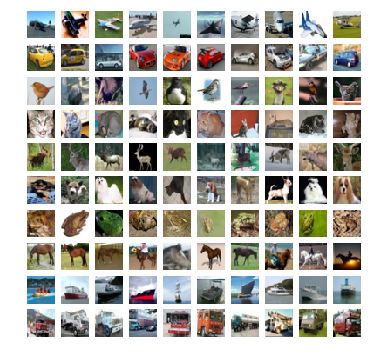

In [6]:
classes = defaultdict(list)
for img, class_ in zip(X_train, y_train):
    classes[class_].append(img)

fig, axes = plt.subplots(10, 10, figsize=(6, 6))
for j in range(10):
    for k in range(10):
        images = classes[j]
        i = np.random.choice(range(len(images)))
        axes[j][k].set_axis_off()
        axes[j][k].imshow(np.transpose(images[i], (1, 2, 0)).astype('uint8'), 
                          interpolation='nearest')

## Benchmark using HOG for feature extraction

Here I used simple solution, just to have some baseline: first extracted features using Histogram of Oriented Gradients, then trained Linear Support Vector Classification and finally tested it and calculated accuration and F1 score.

In [7]:
X_train_hog = hog_feature_extraction(X_train)
X_train_hog = np.array(X_train_hog)

X_test_hog = hog_feature_extraction(X_test)
X_test_hog = np.array(X_test_hog)

In [8]:
svc = LinearSVC()

print("--- Start training")
svc.fit(X_train_hog, y_train)
print("--- SVM prediction on the test set")
y_pred = svc.predict(X_test_hog)

print("SVM: we got results: ACC: %.2f, F1: %.2f" % 
      (acc(y_test, y_pred), f1_score(y_test, y_pred, average='micro')))

--- Start training
--- SVM prediction on the test set
SVM: we got results: ACC: 0.54, F1: 0.54


## Extract visual features

### Preprocessing

In [5]:
X_train[:, 0, :, :] -= 103.939
X_train[:, 1, :, :] -= 116.779
X_train[:, 2, :, :] -= 123.68

X_test[:, 0, :, :] -= 103.939
X_test[:, 1, :, :] -= 116.779
X_test[:, 2, :, :] -= 123.68

In [6]:
print(X_train.shape)
print(X_test.shape)

(50000, 3, 32, 32)
(10000, 3, 32, 32)


### VGG16 (source: https://github.com/fchollet/deep-learning-models)

I used penultimate layer to get visual features.

In [7]:
from vgg16_keras import VGG16

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(3, 32, 32))
model = Model(inputs=[base_model.input], outputs=[base_model.get_layer('block5_pool').output])

cnn_codes_train = model.predict(X_train)
cnn_codes_test = model.predict(X_test)

In [8]:
print(cnn_codes_train.shape)
print(cnn_codes_test.shape)

(50000, 512, 1, 1)
(10000, 512, 1, 1)


### Visualize CNN codes

First I had to reshape data to make it more usefull. Then I used Principal Component Analysis to get two mayor features and plot them into the graph.

In [9]:
cnn_codes_train = cnn_codes_train.reshape(50000, -1)
cnn_codes_test = cnn_codes_test.reshape(10000, -1)

In [11]:
pca = PCA(n_components=2)
fit = pca.fit(cnn_codes_train)
cnn_codes_2 = fit.transform(cnn_codes_train)

In [12]:
df_cnn_codes = pd.DataFrame(cnn_codes_2)
df_cnn_codes.columns = ['PC1', 'PC2']
df_cnn_codes.head()

,PC1,PC2
0,-37.949000,-30.513392
1,101.915716,70.274231
2,-47.859614,-67.404846
3,106.009785,35.571305
4,-1.976412,-20.267363


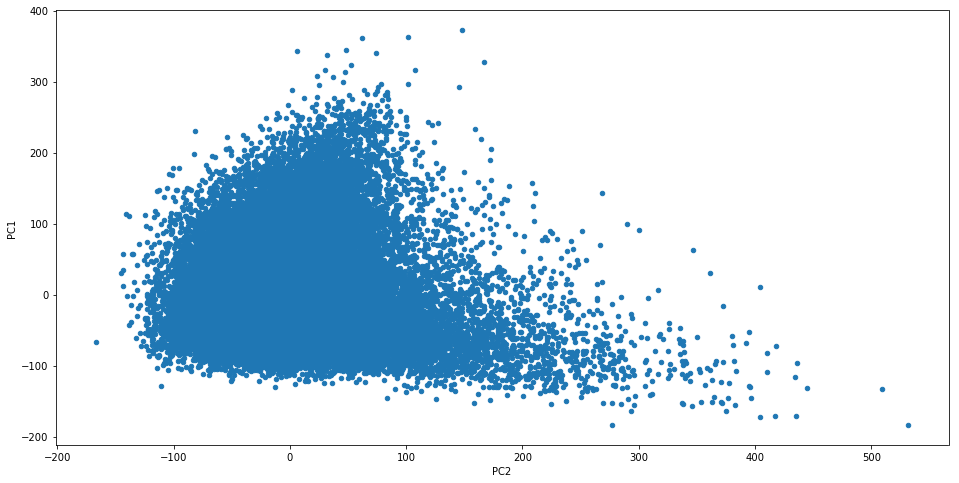

In [13]:
df_cnn_codes.plot(
    kind='scatter',
    x='PC2',
    y='PC1',
    figsize=(16,8))

## SVM classifier using CNN codes

Using previously extracted visual features I trained SVM classifier with different parameters. I used 3-fold cross validation to choose the best parameters.

In [10]:
cnn_codes_train = cnn_codes_train[:10000]
y_train = y_train[:10000]

Unfortunately I had to limit train data to 20% because of my computer's weak parameters.

In [12]:
svc_params = {'kernel': ['rbf', 'linear'], 'gamma': [0.01, 0.001, 0.0001], 'C': [1, 10, 100]}
clf = GridSearchCV(estimator=SVC(), param_grid=svc_params, cv=3, n_jobs=-1, 
                   scoring='accuracy', verbose=10)
clf.fit(cnn_codes_train, y_train)

Fitting 3 folds for each of 18 candidates, totalling 54 fits
[CV] C=1, gamma=0.01, kernel=rbf .....................................
[CV] C=1, gamma=0.01, kernel=rbf .....................................
[CV] C=1, gamma=0.01, kernel=rbf .....................................
[CV] C=1, gamma=0.01, kernel=linear ..................................
[CV] ............ C=1, gamma=0.01, kernel=rbf, score=0.104204 - 2.7min
[CV] C=1, gamma=0.01, kernel=linear ..................................
[CV] ............ C=1, gamma=0.01, kernel=rbf, score=0.104110 - 2.7min
[CV] ............ C=1, gamma=0.01, kernel=rbf, score=0.103986 - 2.7min
[CV] C=1, gamma=0.01, kernel=linear ..................................
[CV] C=1, gamma=0.001, kernel=rbf ....................................
[CV] ........... C=1, gamma=0.001, kernel=rbf, score=0.104885 - 1.8min
[CV] C=1, gamma=0.001, kernel=rbf ....................................
[CV] ........... C=1, gamma=0.001, kernel=rbf, score=0.104710 - 1.7min
[CV] C=1, gamma=

[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  6.2min


[CV] ........... C=1, gamma=0.001, kernel=rbf, score=0.105706 - 1.7min
[CV] C=1, gamma=0.001, kernel=linear .................................
[CV] ......... C=1, gamma=0.01, kernel=linear, score=0.529518 - 8.4min
[CV] C=1, gamma=0.001, kernel=linear .................................
[CV] ......... C=1, gamma=0.01, kernel=linear, score=0.525526 - 6.5min
[CV] C=1, gamma=0.001, kernel=linear .................................
[CV] ........ C=1, gamma=0.001, kernel=linear, score=0.525526 - 6.8min
[CV] C=1, gamma=0.0001, kernel=rbf ...................................
[CV] ........ C=1, gamma=0.001, kernel=linear, score=0.529518 - 8.2min
[CV] C=1, gamma=0.0001, kernel=rbf ...................................


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed: 16.0min


[CV] .......... C=1, gamma=0.0001, kernel=rbf, score=0.439017 - 1.9min
[CV] C=1, gamma=0.0001, kernel=rbf ...................................
[CV] .......... C=1, gamma=0.0001, kernel=rbf, score=0.438344 - 1.9min
[CV] C=1, gamma=0.0001, kernel=linear ................................
[CV] .......... C=1, gamma=0.0001, kernel=rbf, score=0.459459 - 1.7min
[CV] C=1, gamma=0.0001, kernel=linear ................................
[CV] ....... C=1, gamma=0.0001, kernel=linear, score=0.529518 - 8.0min
[CV] C=1, gamma=0.0001, kernel=linear ................................
[CV] ....... C=1, gamma=0.0001, kernel=linear, score=0.525526 - 7.7min
[CV] C=10, gamma=0.01, kernel=rbf ....................................
[CV] ......... C=1, gamma=0.01, kernel=linear, score=0.533453 -31.3min
[CV] C=10, gamma=0.01, kernel=rbf ....................................
[CV] ........... C=10, gamma=0.01, kernel=rbf, score=0.103986 - 2.1min
[CV] C=10, gamma=0.01, kernel=rbf ....................................


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed: 35.9min


[CV] ........... C=10, gamma=0.01, kernel=rbf, score=0.104110 - 2.1min
[CV] C=10, gamma=0.01, kernel=linear .................................
[CV] ........... C=10, gamma=0.01, kernel=rbf, score=0.104204 - 1.8min
[CV] C=10, gamma=0.01, kernel=linear .................................
[CV] ........ C=1, gamma=0.001, kernel=linear, score=0.533453 -31.5min
[CV] C=10, gamma=0.01, kernel=linear .................................
[CV] ........ C=10, gamma=0.01, kernel=linear, score=0.525826 - 4.7min
[CV] C=10, gamma=0.001, kernel=rbf ...................................
[CV] .......... C=10, gamma=0.001, kernel=rbf, score=0.105184 - 1.7min
[CV] C=10, gamma=0.001, kernel=rbf ...................................
[CV] .......... C=10, gamma=0.001, kernel=rbf, score=0.104710 - 1.7min
[CV] C=10, gamma=0.001, kernel=rbf ...................................
[CV] ........ C=10, gamma=0.01, kernel=linear, score=0.529518 -12.8min
[CV] C=10, gamma=0.001, kernel=linear ................................


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed: 49.0min


[CV] .......... C=10, gamma=0.001, kernel=rbf, score=0.105706 - 1.8min
[CV] C=10, gamma=0.001, kernel=linear ................................
[CV] ....... C=1, gamma=0.0001, kernel=linear, score=0.533453 -31.4min
[CV] C=10, gamma=0.001, kernel=linear ................................
[CV] ....... C=10, gamma=0.001, kernel=linear, score=0.525826 - 4.8min
[CV] C=10, gamma=0.0001, kernel=rbf ..................................
[CV] ......... C=10, gamma=0.0001, kernel=rbf, score=0.460294 - 1.7min
[CV] C=10, gamma=0.0001, kernel=rbf ..................................
[CV] ......... C=10, gamma=0.0001, kernel=rbf, score=0.462346 - 1.7min
[CV] C=10, gamma=0.0001, kernel=rbf ..................................
[CV] ......... C=10, gamma=0.0001, kernel=rbf, score=0.475676 - 1.7min
[CV] C=10, gamma=0.0001, kernel=linear ...............................
[CV] ....... C=10, gamma=0.001, kernel=linear, score=0.529518 -13.0min
[CV] C=10, gamma=0.0001, kernel=linear ...............................
[CV] .

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 78.6min


[CV] .......... C=100, gamma=0.01, kernel=rbf, score=0.103986 - 1.7min
[CV] C=100, gamma=0.01, kernel=rbf ...................................
[CV] .......... C=100, gamma=0.01, kernel=rbf, score=0.104110 - 1.7min
[CV] C=100, gamma=0.01, kernel=rbf ...................................
[CV] .......... C=100, gamma=0.01, kernel=rbf, score=0.104204 - 1.7min
[CV] C=100, gamma=0.01, kernel=linear ................................
[CV] ....... C=100, gamma=0.01, kernel=linear, score=0.529518 -12.8min
[CV] C=100, gamma=0.01, kernel=linear ................................
[CV] ....... C=10, gamma=0.01, kernel=linear, score=0.533453 -153.5min
[CV] C=100, gamma=0.01, kernel=linear ................................
[CV] ....... C=100, gamma=0.01, kernel=linear, score=0.525826 - 4.9min
[CV] C=100, gamma=0.001, kernel=rbf ..................................
[CV] ......... C=100, gamma=0.001, kernel=rbf, score=0.105184 - 1.7min
[CV] C=100, gamma=0.001, kernel=rbf ..................................
[CV] .

[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 201.2min


[CV] ...... C=10, gamma=0.001, kernel=linear, score=0.533453 -152.5min
[CV] C=100, gamma=0.001, kernel=linear ...............................
[CV] ...... C=100, gamma=0.001, kernel=linear, score=0.529518 -12.6min
[CV] C=100, gamma=0.001, kernel=linear ...............................
[CV] ..... C=10, gamma=0.0001, kernel=linear, score=0.533453 -153.1min
[CV] C=100, gamma=0.0001, kernel=rbf .................................
[CV] ........ C=100, gamma=0.0001, kernel=rbf, score=0.460294 - 1.6min
[CV] C=100, gamma=0.0001, kernel=rbf .................................
[CV] ...... C=100, gamma=0.001, kernel=linear, score=0.525826 - 4.3min
[CV] C=100, gamma=0.0001, kernel=rbf .................................
[CV] ........ C=100, gamma=0.0001, kernel=rbf, score=0.462346 - 1.7min
[CV] C=100, gamma=0.0001, kernel=linear ..............................
[CV] ........ C=100, gamma=0.0001, kernel=rbf, score=0.475676 - 1.7min
[CV] C=100, gamma=0.0001, kernel=linear ..............................
[CV] .

[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed: 806.6min finished


GridSearchCV(cv=3, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'kernel': ['rbf', 'linear'], 'gamma': [0.01, 0.001, 0.0001], 'C': [1, 10, 100]},
       pre_dispatch='2*n_jobs', refit=True, scoring='accuracy', verbose=10)

And finally, I found the best parameters and got results:

In [13]:
y_pred = clf.predict(cnn_codes_test)
print("For params: %s we got results: acc: %.2f, F1: %.2f" % 
      (str(clf.best_params_), acc(y_test, y_pred), f1_score(y_test, y_pred, average='micro')))

For params: {'C': 10, 'gamma': 0.01, 'kernel': 'linear'} we got results: acc: 0.53, F1: 0.53


I am pretty sure it is not the best possible results, but probably it is so low because of limited data.

## Stacking

Maybe I should not take only one model with the best result? Maybe those models with almost the same accuracy are also worth to consider? I am going to take few models with the best score and then stack their results.

Firstly I took five models with the highest mean accuracy as k-fold validation's result, train them once again and then take those with highest accuracy on the validation set.

In [82]:
predicts = sorted([(grid[1], grid[0]) for grid in clf.grid_scores_], key=lambda x: x[0])[-5:]
cnn_codes_train, cnn_codes_val, y_train, y_val = train_test_split(cnn_codes_train, y_train, test_size=0.2)
models = []

for params in predicts:
    model = SVC(**params[1])
    model.fit(cnn_codes_train, y_train)
    y_pred = model.predict(cnn_codes_val)
    accuracy = acc(y_val, y_pred)
    models.append({'model': model, 'params': params[1], 'acc': accuracy})
    print("params: %s, accuracy: %.2f" % (str(params[1]), accuracy))

params: {'C': 1, 'gamma': 0.001, 'kernel': 'linear'}, accuracy: 0.53
params: {'C': 1, 'gamma': 0.0001, 'kernel': 'linear'}, accuracy: 0.53
params: {'C': 10, 'gamma': 0.01, 'kernel': 'linear'}, accuracy: 0.53
params: {'C': 10, 'gamma': 0.001, 'kernel': 'linear'}, accuracy: 0.53
params: {'C': 10, 'gamma': 0.0001, 'kernel': 'linear'}, accuracy: 0.53


The difference between their accuracies is small, so I decided to use all models. 

In [84]:
results = []
for model in models:
    y_pred = model['model'].predict(cnn_codes_test)
    print("Testing model with parameters %s is done" % str(model['params']))
    results.append(y_pred)

Testing model with parameters {'C': 1, 'gamma': 0.001, 'kernel': 'linear'} is done
Testing model with parameters {'C': 1, 'gamma': 0.0001, 'kernel': 'linear'} is done
Testing model with parameters {'C': 10, 'gamma': 0.01, 'kernel': 'linear'} is done
Testing model with parameters {'C': 10, 'gamma': 0.001, 'kernel': 'linear'} is done
Testing model with parameters {'C': 10, 'gamma': 0.0001, 'kernel': 'linear'} is done


In [126]:
results_pd = pd.DataFrame(results)
results_pd = results_pd.transpose()
y_pred = results_pd.mode(axis=1).values.reshape(10000)

### And finally... my result:

In [132]:
print("Final accuracy: %f, F1: %f" % (acc(y_test, y_pred), f1_score(y_test, y_pred, average='micro')))

Final accuracy: 0.532200, F1: 0.532200


Well, after a lot of hours of training and choosing the best parameters I was not able to beat the benchmark's results. I used only 20% of training data, so probably that is the reason.